# Stock Market Prediction using Time-series and Daily News Analysis
## Long Short Term Memory (LSTM)
### Preprocessing and Modeling

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from math import sqrt
import datetime as dt

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,6

pd.set_option('mode.chained_assignment', 'raise') # Raise an exception, warn, or no action if trying to use chained assignment

In [2]:
# Read the combines stock index CSV data file from the data directory
dataset = pd.read_csv('data/comb_data_final.csv',index_col='Date',parse_dates=True)

In [3]:
# Create a separate dataset with just the Adj Close column
new_data = dataset[['Adj Close']]
new_data.head()

,Adj Close
Date,
2008-08-08,11734.320312
2008-08-11,11782.349609
2008-08-12,11642.469727
2008-08-13,11532.959961
2008-08-14,11615.929688


In [4]:
new_data.shape

(1989, 1)

In [5]:
# Set the threshold two years before the last date (at the beginning of 7th year)
threshold = dataset.index.max() - pd.DateOffset(years=2) 
# Create Train and Test datasets
X_train = dataset[dataset.index <= threshold][['Adj Close']]
X_test = dataset[dataset.index > threshold][['Adj Close']]
X_train.shape, X_test.shape

((1484, 1), (505, 1))

In [6]:
len(X_train)

1484

In [7]:
type(X_train)

pandas.core.frame.DataFrame

In [8]:
new_data

,Adj Close
Date,
2008-08-08,11734.320312
2008-08-11,11782.349609
2008-08-12,11642.469727
2008-08-13,11532.959961
2008-08-14,11615.929688
...,...
2016-06-27,17140.240234
2016-06-28,17409.720703
2016-06-29,17694.679688


In [9]:
# Let's scale the dataset for the purposes of LSTM since this is a sequence prediction problem
# If we dont scale, it is possible for large inputs to slow down the learning and convergence of the network and prevent the network from effectively learning your problem
# Convert dataset into x_train_scaled and y_train_scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train) # do we scale full dataset or X_train?

x_train, y_train = [], []
for i in range(60,len(X_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # same as x_train.reshape(len(x_train),len(x_train[0]),1)

In [10]:
x_train.shape

(1424, 60, 1)

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(Dropout(0.2)) # do I need dropouts to prevent overfitting?
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2) 
# effects of changing epochs? less error?

Epoch 1/5
1424/1424 - 18s - loss: 0.0021
Epoch 2/5
1424/1424 - 19s - loss: 6.6567e-04
Epoch 3/5
1424/1424 - 18s - loss: 4.9466e-04
Epoch 4/5
1424/1424 - 18s - loss: 4.6556e-04
Epoch 5/5
1424/1424 - 18s - loss: 3.3070e-04


In [13]:
#predicting 505 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(X_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
for i in range(60,inputs.shape[0]):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
predicted_closing_price = model.predict(x_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [17]:
inputs.shape

(565, 1)

In [15]:
predicted_closing_price.shape

(505, 1)

In [19]:
# Evaluate LSTM model error (RMSE value)
rmse=np.sqrt(np.mean(np.power((X_test-predicted_closing_price),2)))
rmse

Adj Close    230.340237
dtype: float64

In [25]:
# Let's plot the dataset with predictions from our model
# First, create a copy of the test dataset and add the prediction column to the copy test set
X_test_copy = X_test.copy()
X_test_copy.loc[:, 'preds'] = predicted_closing_price

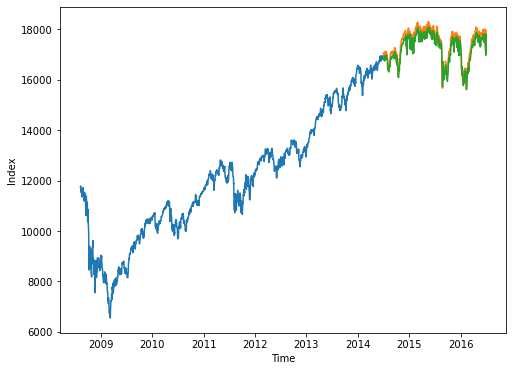

In [28]:
#for plotting
plt.figure(figsize=(8, 6))
plt.plot(X_train['Adj Close'])
plt.plot(X_test_copy[['Adj Close', 'preds']])
plt.xlabel('Time')
plt.ylabel('Index');

### Conclusion
The LSTM model has resulted in the lowest error by far among the other models.